https://github.com/OctoberChang/MMD-GAN - accompanying the paper MMD-GAN: Towards Deeper Understanding of Moment Matching Network.

To check GPU usage, open new terminal inside Jupyter and nvidia-smi

In [1]:
import argparse
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.utils as vutils
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import os
import h5py
import timeit
import time
import numpy as np
from scipy import stats
import pickle as pkl
from os import listdir
from os.path import isfile, join



/share/apps/python3/3.6.3/intel/lib/python3.6/site-packages/h5py-2.7.1-py3.6-linux-x86_64.egg/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
run_in_jupyter = False
try:
    cfg = get_ipython().config 
    run_in_jupyter = True
except:
    run_in_jupyter = False
    pass

if run_in_jupyter:
    import matplotlib.pyplot as plt
    %matplotlib inline
else: 
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    
print("Run in Jupyter = " + str(run_in_jupyter))

Run in Jupyter = True


In [3]:
import itertools
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import h5py
import matplotlib as mpl
from pathlib import Path

In [4]:
# Arguments
batch_size = 16       # BATCH_SIZE: batch size for training
workers = 2          # WORKERS: number of threads to load data

experiment = "./mmd_gan_fc/"       # : output directory of saved models
model_save_folder = experiment + "model/"
save_model_every = 10               # (every x epoch) frequency to save the model

redshift_info_folder = experiment + "redshift_info/"   # save some info here as pickle to speed up processing
redshift_file = "minmax_scale_01_redshift0.h5"    # redshift cube to be used
root_dir = ""                                     # should be "" fo prince
redshift_fig_folder = experiment + "figures/"        # folder to save mmd & related plots
redshift_3dfig_folder = experiment + "/3d_figures/"   # folder to save 3D plots
testing_folder = experiment + "testing/"   # folder to save 3D plots


gpu_device = 0        # GPU_DEVICE: gpu id (default 0)
nc = 1                # NC: number of channels in images
nz = 2048                # NZ: hidden dimension in z and codespace
cube_size = 128       # IMAGE_SIZE: image size of dataset - 
                        # for our dataset more like one edge of the subcube
lr = 5e-5               # LR: learning rate (default 5e-5)
max_iter = 150         # MAX_ITER: max iteration for training

optimizer_choice = "rmsprop"     # adam or rmsprop
dist_ae = 'L1'                  # "L2" or "L1" or "cos" -> Autoencoder reconstructruced cube loss choice
manual_seed = 1126
n_samples = batch_size * 128      # on prince, number of samples to get from the training cube
in_testing = False              # True if doing testing

viz_multiplier = 3e1    # the norm multiplier in the 3D visualization




In [5]:
assert n_samples / batch_size > 100, "The gen_iterations wont work properly!"

## Parameter Documentation

In [6]:
print("Batch Size = " + str(batch_size))
print("Redshift File Used = " + str(redshift_file))
print("Number of Channels in Input = " + str(nc))
print("Hidden Dimension (codespace) = " + str(nz))
print("Length of Edge of a Sampled Subcube = " + str(cube_size))
print("Learning Rate = " + str(lr))
print("Number of Epochs = " + str(max_iter))
print("Optimizer = " + str(optimizer_choice))
print("Autoencoder Reconstruction Loss  = " + str(dist_ae))
print("Seed = " + str(manual_seed))
print("Number of Samples = " + str(n_samples))
print("Visualization Multiplier = " + str(viz_multiplier))

Batch Size = 16
Redshift File Used = minmax_scale_01_redshift0.h5
Number of Channels in Input = 1
Hidden Dimension (codespace) = 2048
Length of Edge of a Sampled Subcube = 128
Learning Rate = 5e-05
Number of Epochs = 150
Optimizer = rmsprop
Autoencoder Reconstruction Loss  = L1
Seed = 1126
Number of Samples = 2048
Visualization Multiplier = 30.0


In [7]:
edge_sample = 128
edge_test = 1024

print("one edge of the test partition of the whole cube = " + str(edge_test))
print("one edge of the sampled subcubes =  " + str(edge_sample))


one edge of the test partition of the whole cube = 1024
one edge of the sampled subcubes =  128


### MMD Parameters

In [8]:
"""
MMD Parameters

errD = torch.sqrt(mmd2_D) + lambda_rg * one_side_errD 
       - lambda_AE_X * L2_AE_X_D - lambda_AE_Y * L2_AE_Y_D
       
errG = torch.sqrt(mmd2_G) + lambda_rg * one_side_errG

The explanations can be found in Ratio Matching MMD Nets (2018) in 
Equation 3.

"""

lambda_MMD = 1.0   # not used anywhere
lambda_AE_X = 8.0  # used in above calc only 
lambda_AE_Y = 8.0  # used in above calc only
lambda_rg = 16.0   # used in both err calcs

print("lambda_MMD = " + str(lambda_MMD))
print("lambda_AE_X = " + str(lambda_AE_X))
print("lambda_AE_Y = " + str(lambda_AE_Y))
print("lambda_rg = " + str(lambda_rg))


lambda_MMD = 1.0
lambda_AE_X = 8.0
lambda_AE_Y = 8.0
lambda_rg = 16.0


In [9]:
"""
sigma for MMD
"""
base = 1.0
sigma_list = [1, 2, 4, 8, 16]
sigma_list = [sigma / base for sigma in sigma_list]
print("sigma_list = " + str(sigma_list))

sigma_list = [1.0, 2.0, 4.0, 8.0, 16.0]


In [10]:
"""
used at:
def _mmd2_and_ratio(K_XX, K_XY, K_YY, 
                    const_diagonal=False, 
                    biased=False):
    mmd2, var_est = _mmd2_and_variance(K_XX, K_XY, K_YY, 
                                       const_diagonal=const_diagonal, 
                                       biased=biased)
    loss = mmd2 / torch.sqrt(torch.clamp(var_est, min=min_var_est))
    return loss, mmd2, var_est
    
torch.clamp(input, min, max, out=None) → Tensor
    Clamp all elements in input into the range [ min, max ] 
    and return a resulting tensor
"""

# min_var_est = 1e-8
min_var_est = 1e-30

print("minimum variance estimated = " + str(min_var_est))

minimum variance estimated = 1e-30


## Redshift Data Load

In [11]:
f = h5py.File(root_dir + redshift_file, 'r')
print(f.filename)
f = f['delta_HI']

minmax_scale_01_redshift0.h5


## Redshift Info Load

In [12]:
# create experiment folder if it doesn't exist
if Path(redshift_info_folder).exists() == False:
    os.mkdir(experiment)
    
# create redshift info folder if it doesn't exist
if Path(redshift_info_folder).exists() == False:
    os.mkdir(redshift_info_folder)

In [13]:
def get_max_cube(f):
    max_list = [np.max(f[i:i+1,:,:]) for i in range(f.shape[0])]
    max_cube = max(max_list)
    return max_cube

def get_min_cube(f):
    min_list = [np.min(f[i:i+1,:,:]) for i in range(f.shape[0])]
    min_cube = min(min_list)
    return min_cube

In [14]:
# check if redshift info (min & max exists) as pickle
# if not saved, find the max and min and save them for later use
min_cube_file = Path(redshift_info_folder + redshift_file + "_min_cube" + ".npy")
max_cube_file = Path(redshift_info_folder + redshift_file + "_max_cube" + ".npy")


if not min_cube_file.exists() or not max_cube_file.exists():
    
    f = h5py.File(root_dir + redshift_file, 'r')
    f=f['delta_HI']
    
    # get the min and max
    min_cube = get_min_cube(f=f)
    print(min_cube)
    max_cube = get_max_cube(f=f)
    print(max_cube)
    
    np.save(file = redshift_info_folder + redshift_file + "_min_cube",
        arr = min_cube,
        allow_pickle = True)
    np.save(file = redshift_info_folder + redshift_file + "_max_cube",
        arr = max_cube,
        allow_pickle = True)
    

In [15]:
min_cube = np.load(file = redshift_info_folder + redshift_file + "_min_cube" + '.npy')
max_cube = np.load(file = redshift_info_folder + redshift_file + "_max_cube" + '.npy')
print("Min of data = " + str(min_cube))
print("Max of data = " + str(max_cube))


Min of data = 0.0
Max of data = 1.0


## Figures Handling

In [16]:
# create figures folder if it doesn't exist
if Path(redshift_fig_folder).exists() == False:
    os.mkdir(redshift_fig_folder)
if Path(redshift_3dfig_folder).exists() == False:
    os.mkdir(redshift_3dfig_folder)

## 3D Plot

In [17]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """Function for dividing/truncating cmaps"""
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def visualize_cube(cube=None,      # array name
             edge_dim=None,        # edge dimension (128 for 128 x 128 x 128 cube)
             start_cube_index_x=0,
             start_cube_index_y=0,
             start_cube_index_z=0,
             fig_size=None,
             stdev_to_white=1,
             norm_multiply=viz_multiplier,
             color_map="Blues",
             plot_show = False,
             save_fig = False):
    
    """
    The inputs should be in the interval [0,1]
    All the transformations on the input
    should be done before passing
    into the function.
    """
        
    cube_size = edge_dim
    edge = np.array([*range(cube_size)])
    
    end_x = start_cube_index_x + cube_size
    end_y = start_cube_index_y + cube_size
    end_z = start_cube_index_z + cube_size
    
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111, projection='3d')
    
    data_value = cube[start_cube_index_x:end_x,
                      start_cube_index_y:end_y,
                      start_cube_index_z:end_z]
    
    x,y,z = edge,edge,edge
    product = [*itertools.product(x,y,z)]
    
    X = np.array([product[k][0] for k in [*range(len(product))]])
    Y = np.array([product[k][1] for k in [*range(len(product))]])
    Z = np.array([product[k][2] for k in [*range(len(product))]])
    
    ## map data to 1d array that corresponds to the axis values in the product array
    data_1dim = np.array([data_value[X[i]][Y[i]][Z[i]] for i in [*range(len(product))]])
    
    
    initial_mean = np.mean(data_1dim) - stdev_to_white*np.std(data_1dim)
    mask = data_1dim > initial_mean
    mask = mask.astype(np.int)
    
    data_1dim = np.multiply(mask,data_1dim)
    ## mask X,Y,Z to match the dimensions of the data
    X, Y, Z, data_1dim = [axis[np.where(data_1dim>0)] for axis in [X,Y,Z,data_1dim]]

    
    
#     if lognormal == False:
    """
    norm_multiply = function argument
    data_1dim = data in one dimension, flattened
    nn.linalg.norm = return one of eight different matrix norms

    The nn.linalg.norm should not be used due to the fact 
    that each subcube has different norms. Use the maximum of
    the whole cube and mitigate with norm_multiply if 
    no points are seen in the 3D plot.
    """
        
#         s = norm_multiply*data_1dim/np.linalg.norm(data_1dim)
    s = norm_multiply * data_1dim

    # adding this for [-1,1] scaled input
    # so that s is between [0,1]
#         s = (s + 1.0) / 2.0 
    
#     else:
#         s = np.log(norm_multiply*data_1dim/np.linalg.norm(data_1dim))
    try:
        # checking min, max , mean of s
        print("Plotting s (= norm_multiply * data_1dim) stats:")
        print("s mean = " + str(s.mean()))
        print("s max = " + str(s.max()))
        print("s min = " + str(s.min()))


        cmap=plt.get_cmap(color_map)
        new_cmap = truncate_colormap(cmap, 0.99, 1,n=10)

        ## IGNORE BELOW 3D PLOT FORMATTING 

        ## plot cube

        cube_definition = [(start_cube_index_x, start_cube_index_x, start_cube_index_x),
                          (start_cube_index_x, start_cube_index_x+edge_dim, start_cube_index_x),
                          (start_cube_index_x + edge_dim, start_cube_index_x, start_cube_index_x),
                          (start_cube_index_x, start_cube_index_x, start_cube_index_x+edge_dim)]

        cube_definition_array = [
            np.array(list(item))
            for item in cube_definition
        ]

        points = []
        points += cube_definition_array
        vectors = [
            cube_definition_array[1] - cube_definition_array[0],
            cube_definition_array[2] - cube_definition_array[0],
            cube_definition_array[3] - cube_definition_array[0]
        ]


        points += [cube_definition_array[0] + vectors[0] + vectors[1]]
        points += [cube_definition_array[0] + vectors[0] + vectors[2]]
        points += [cube_definition_array[0] + vectors[1] + vectors[2]]
        points += [cube_definition_array[0] + vectors[0] + vectors[1] + vectors[2]]

        points = np.array(points)

        edges = [
            [points[0], points[3], points[5], points[1]],
            [points[1], points[5], points[7], points[4]],
            [points[4], points[2], points[6], points[7]],
            [points[2], points[6], points[3], points[0]],
            [points[0], points[2], points[4], points[1]],
            [points[3], points[6], points[7], points[5]]
        ]

    #     ax.fig.add_subplot(111, projection='3d')

        faces = Poly3DCollection(edges, linewidths=1, edgecolors='k',)
        faces.set_facecolor((0,0,1,0)) ## set transparent facecolor to the cube

        ax.add_collection3d(faces)

        ax.scatter(points[:,0], points[:,1], points[:,2], s=0)

        ax.set_aspect('equal')

        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False

        ax.xaxis.pane.set_edgecolor('w')
        ax.yaxis.pane.set_edgecolor('w')
        ax.zaxis.pane.set_edgecolor('w')

        ax.xaxis.set_major_locator(MultipleLocator(edge_dim))
        ax.yaxis.set_major_locator(MultipleLocator(edge_dim))
        ax.zaxis.set_major_locator(MultipleLocator(edge_dim))

        ax.grid(False)

        ax.set_xlim3d(0,edge_dim)
        ax.set_ylim3d(0,edge_dim)
        ax.set_zlim3d(0,edge_dim)
    #     ax.get_frame_on()

        ax.xaxis._axinfo['tick']['inward_factor'] = 0
        ax.xaxis._axinfo['tick']['outward_factor'] = 0
        ax.yaxis._axinfo['tick']['inward_factor'] = 0
        ax.yaxis._axinfo['tick']['outward_factor'] = 0
        ax.zaxis._axinfo['tick']['inward_factor'] = 0
        ax.zaxis._axinfo['tick']['outward_factor'] = 0

        ax.scatter(X, Y, Z,       ## axis vals
                   c=data_1dim,   ## data, mapped to 1-dim
                   cmap=new_cmap,
                   s=s,           ## sizes - dims multiplied by each data point's magnitude
                   alpha=0.7,
                   edgecolors="face")

        if plot_show:
            plt.show()


        if save_fig:
            fig.savefig(save_fig,bbox_inches='tight')

        plt.close(fig)
    
    except:
        pass



## Data Loader

In [18]:
def define_test(s_test, s_train):
    """
    s_test = one edge of the test partition of the whole cube
    s_train = one edge of the sampled subcubes
    """
    #2048/16=128
    m = 8
    x = random.randint(0,m) * s_train
    y = random.randint(0,m) * s_train
    z = random.randint(0,m) * s_train
    #print(x,y,z)
    return {'x':[x,x + s_test], 'y':[y,y + s_test], 'z':[z,z + s_test]}

In [ ]:
def check_coords(test_coords, train_coords):
    valid=True
    for i in ['x','y','z']:
        r=(max(test_coords[i][0], 
               train_coords[i][0]), 
           min(test_coords[i][1],
               train_coords[i][1]))
        if r[0]<=r[1]:
            valid=False
    return valid

In [ ]:
time_2_list = []
time_3_list = []


In [ ]:
def get_samples(s_sample, 
                nsamples, 
#                 h5_filename,  
                test_coords,
                f):   # given as f["delta_HI"]
    #n is size of minibatch, get valid samples (not intersecting with test_coords)
    sample_list=[]
    m = 2048 - 128
    
    
    for n in range(nsamples):
        #print("Sample No = " + str(n + 1) + " / " + str(nsamples))
        sample_valid = False
        while sample_valid == False:
            x = random.randint(0,m)
            y = random.randint(0,m)
            z = random.randint(0,m)
            sample_coords = {'x':[x,x+s_sample], 
                             'y':[y,y+s_sample], 
                             'z':[z,z+s_sample]}
            
            sample_valid = check_coords(test_coords, 
                                        sample_coords)
        
        sample_list.append(sample_coords)
    
#     print("Sampling subcube edges finished.")
        
    #Load cube and get samples and convert them to np.arrays
    sample_array=[]
    

#     time_1 = time.time()
#     f = h5py.File(h5_filename, 'r') 
#     f=f_deltaHI
    
    counter = 0
    for c in sample_list:
#         print("Counter = " + str(counter + 1) + " / " + str(len(sample_list)))
        a = f[c['x'][0]:c['x'][1],
              c['y'][0]:c['y'][1],
              c['z'][0]:c['z'][1]]
#         time_2 = time.time()
        
        a = np.array(a)
        
    
        sample_array.append(a)
    
        counter = counter + 1
    
#     time_3 = time.time() - time_2
#     time_2 = time_2 - time_1
    
#     print("time_2 = " + str(time_2))
#     print("time_3 = " + str(time_3))
#     time_2_list.append(time_2)
#     time_3_list.append(time_3)
#     print_count = random.randint(a=0,b=40)
#     if print_count % 40 == 0:
#         print("time_2 mean = " + str(np.mean(np.array(time_2_list))))
#         print("time_3 mean = " + str(np.mean(np.array(time_3_list))))

        
#     f = 0
    return sample_array



In [ ]:
testcd = define_test(s_test = edge_test, s_train = edge_sample)
testcd

{'x': [768, 1792], 'y': [896, 1920], 'z': [384, 1408]}

In [ ]:
trial_sample = get_samples(s_sample = edge_sample, 
                            nsamples = 1, 
#                             h5_filename = redshift_file, 
                            test_coords = testcd,
                            f = f)
trial_sample

[array([[[2.43170371e-12, 2.39546826e-13, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          5.40747395e-12, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          3.02261818e-12, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 1.75265236e-11, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [2.03687883e-11, 9.33471182e-12, 1.83269754e-11, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.73908381e-12, 4.01158360e-12, 8.44452720e-12, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
 
        [[2.35032154e-13, 2.31529849e-14, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          9.26560478e-12, 0.00000000e+00, 0.00000000e+00],
       

In [ ]:
trial_sample[0].shape

(128, 128, 128)

In [ ]:
trial_sample[0].reshape(-1,).shape

(2097152,)

In [ ]:
trial_plot = trial_sample[0].reshape(-1,)

In [ ]:
# [-1,1] -> [0,1] for plotting
# trial_plot = (trial_plot + 1.0) / 2.0

In [ ]:
trial_plot.min()

0.0

In [ ]:
trial_plot.max()

0.0478183813393116

In [ ]:
trial_plot.sum()

0.5931218945774503

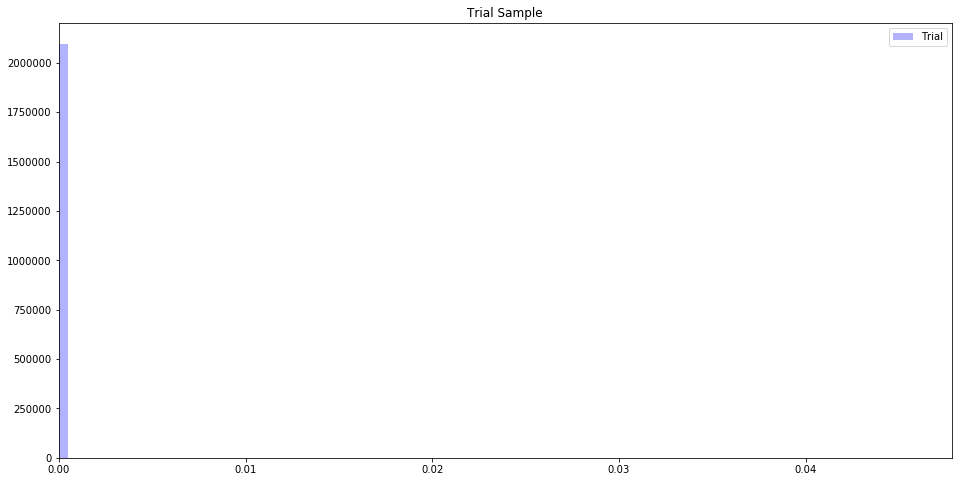

In [ ]:
plt.figure(figsize = (16,8))
plt.title("Trial Sample")
plt.xlim((trial_plot.min(),
         trial_plot.max()))
bins = np.linspace(trial_plot.min(),
                   trial_plot.max(), 
                   100)
plt.hist(trial_plot, bins = bins, 
         color = "blue" ,
         alpha = 0.3, 
         label = "Trial")
plt.legend()
plt.show()

(128, 128, 128)
edge dim = 128
(128, 128, 128)
Plotting s (= norm_multiply * data_1dim) stats:
s mean = 15.059174078219135
s max = 15.717275720089674
s min = 15.00250650315138


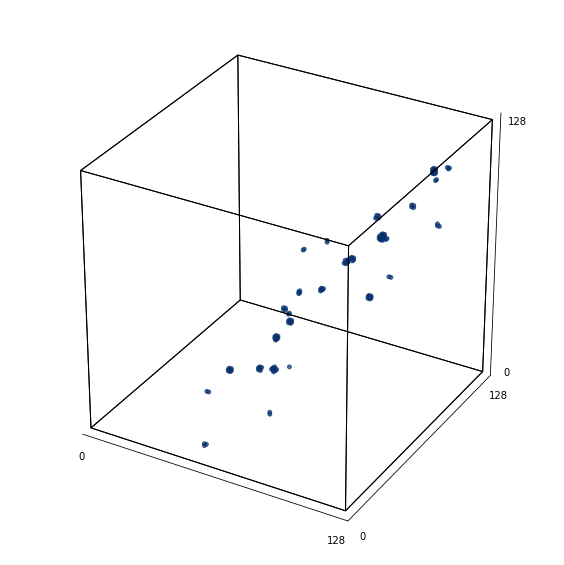

In [ ]:
trial_visual = trial_sample[0]
print(trial_visual.shape)
trial_visual_edge = trial_visual.shape[0]
print("edge dim = " + str(trial_visual_edge))

# from [-1,1] to [0,1]
trial_visual = (trial_visual + 1.0) / 2.0
print(trial_visual.shape)

visualize_cube(cube=trial_visual,      ## array name
             edge_dim=trial_visual_edge,        ## edge dimension (128 for 128 x 128 x 128 cube)
             start_cube_index_x=0,
             start_cube_index_y=0,
             start_cube_index_z=0,
             fig_size=(10,10),
             stdev_to_white=-2,
             norm_multiply=viz_multiplier,
             color_map="Blues",
             plot_show = True,
             save_fig = False)

## Checking Duplicates in Sampled Subcubes

In [ ]:
s_sample = edge_sample 
nsamples = 10000

testcd = define_test(s_test = edge_test,
                     s_train = edge_sample)
print(testcd)

sample_list=[]
m = 2048 - 128


for n in range(nsamples):
    #print("Sample No = " + str(n + 1) + " / " + str(nsamples))
    sample_valid = False
    while sample_valid == False:
        x = random.randint(0,m)
        y = random.randint(0,m)
        z = random.randint(0,m)
        sample_coords = {'x':[x,x+s_sample], 
                         'y':[y,y+s_sample], 
                         'z':[z,z+s_sample]}

        sample_valid = check_coords(testcd, 
                                    sample_coords)

    sample_list.append(sample_coords)

print(len(sample_list))
# print(len(list(set(sample_list))))
sample_df = pd.DataFrame.from_dict(sample_list)
dropped_sample_df = sample_df.applymap(lambda x: x[0]).drop_duplicates()

sample_df.shape[0] == dropped_sample_df.shape[0]



{'x': [768, 1792], 'y': [128, 1152], 'z': [256, 1280]}
10000


False

## Dataset & DataLoader

In [ ]:
class HydrogenDataset2(Dataset):
    """Hydrogen Dataset"""

    def __init__(self, h5_file, root_dir, s_test, s_train,
                 s_sample, nsamples):
        """
        Args:
            h5_file (string): name of the h5 file with 32 sampled cubes.
            root_dir (string): Directory with the .h5 file.
        """
        file_size = os.path.getsize(root_dir + h5_file) / 1e6 # in MBs
#         print("The whole file size is " + str(int(file_size)) + " MBs")
        
        # self.subcubes = h5py.File('../data/sample_32.h5', 'r')
#         self.f = f_deltaHI
        self.h5_file = h5_file
        self.root_dir = root_dir
        self.s_test = s_test
        self.s_train = s_train
        self.t_coords = define_test(self.s_test,
                                    self.s_train)
        self.s_sample = s_sample
        self.nsamples = nsamples
        self.h5_filename = self.root_dir + self.h5_file
        
#         self.samples = get_samples(s_sample = self.s_sample,
#                              nsamples = self.nsamples,
#                              h5_filename = self.h5_filename,
#                              test_coords = self.t_coords)
#         print("Got self.samples")
        
        self.min_val = min_cube
#         print("min = " + str(self.min_val))
        self.max_val = max_cube
#         print("max = " + str(self.max_val))

    def __len__(self):
        # Function called when len(self) is executed
        
        #print(len(self.subcubes))
#         return len(self.nsamples)
        return self.nsamples

    def __getitem__(self, idx):
        """
        This can be implemented in such a way that the whole h5 file read 
        using h5py.File() and get_sample() function is called to return
        a random subcube. This won't increase memory usage because the
        subcubes will be read in the same way and only the batch will
        be read into memory.
        
        Here we have implemented it so that it can be used with data
        generated by get_sample() function.
        
        The output of this function is one subcube with the dimensions
        specified by get_sample() implementation.
        """
        
        # default version -> error in training because of dimensions
#         sample = self.subcubes[idx]
        
        # reshaped version to add another dimension
#         sample = self.subcubes[idx].reshape((1,128,128,128))

        # On prince using get_samples()
#         print("nsamples = " + str(self.nsamples))
        sample = get_samples(s_sample = self.s_sample,
                             nsamples = 1,
#                              h5_filename = self.h5_filename,
                             test_coords = self.t_coords,
                            f = f)
    
#         sample = self.samples[idx].reshape((1,128,128,128))

        sample = np.array(sample).reshape((1,self.s_sample,self.s_sample,self.s_sample))
        
        # added division by 1e6 for exploding variance
        # and resulting in inf during reparametrization trick part
#         sample = sample/1e6

        return sample

In [ ]:
# on prince
sampled_subcubes = HydrogenDataset2(h5_file=redshift_file,
                                    root_dir = root_dir,
                                    s_test = edge_test, 
                                    s_train = edge_sample,
                                    s_sample = edge_sample, 
                                    nsamples = n_samples)

In [ ]:
# Get data
trn_loader = torch.utils.data.DataLoader(sampled_subcubes, 
                                         batch_size = batch_size,
                                         shuffle=True, 
                                         num_workers=int(workers))

## Model

In [ ]:
# Consider linear time MMD with a linear kernel:
# K(f(x), f(y)) = f(x)^Tf(y)
# h(z_i, z_j) = k(x_i, x_j) + k(y_i, y_j) - k(x_i, y_j) - k(x_j, y_i)
#             = [f(x_i) - f(y_i)]^T[f(x_j) - f(y_j)]
#
# f_of_X: batch_size * k
# f_of_Y: batch_size * k
def linear_mmd2(f_of_X, f_of_Y):
    loss = 0.0
    delta = f_of_X - f_of_Y
    loss = torch.mean((delta[:-1] * delta[1:]).sum(1))
    return loss

In [ ]:
# Consider linear time MMD with a polynomial kernel:
# K(f(x), f(y)) = (alpha*f(x)^Tf(y) + c)^d
# f_of_X: batch_size * k
# f_of_Y: batch_size * k
def poly_mmd2(f_of_X, f_of_Y, d=2, alpha=1.0, c=2.0):
    K_XX = (alpha * (f_of_X[:-1] * f_of_X[1:]).sum(1) + c)
    K_XX_mean = torch.mean(K_XX.pow(d))

    K_YY = (alpha * (f_of_Y[:-1] * f_of_Y[1:]).sum(1) + c)
    K_YY_mean = torch.mean(K_YY.pow(d))

    K_XY = (alpha * (f_of_X[:-1] * f_of_Y[1:]).sum(1) + c)
    K_XY_mean = torch.mean(K_XY.pow(d))

    K_YX = (alpha * (f_of_Y[:-1] * f_of_X[1:]).sum(1) + c)
    K_YX_mean = torch.mean(K_YX.pow(d))

    return K_XX_mean + K_YY_mean - K_XY_mean - K_YX_mean

In [ ]:
def _mix_rbf_kernel(X, Y, sigma_list):
    """
    Inputs:
        X -> f_enc_X_D ->
            size = batch_size x nz 
                nz = hidden dimension of z
        Y -> f_enc_Y_D -> 
            size = batch_size x nz 
                nz = hidden dimension of z
        sigma_list -> 
            base = 1.0
            sigma_list = [1, 2, 4, 8, 16]
            sigma_list = [sigma / base for sigma in sigma_list] 
            
    m = batch_size
    torch.cat(seq, dim=0, out=None) → Tensor
        Concatenates the given sequence of seq tensors 
        in the given dimension
    Z size = [2 x batch_size, nz]
    
    torch.mm(mat1, mat2, out=None) → Tensor
        Performs a matrix multiplication of the matrices mat1 and mat2
    ZZT size = [2 x batch_size, 2 x batch_size]
    
    torch.diag(input, diagonal=0, out=None) → Tensor
        If input is a matrix (2-D tensor), then returns a 1-D tensor 
        with the diagonal elements of input
    torch.unsqueeze(input, dim, out=None) → Tensor
        Returns a new tensor with a dimension of size 
        one inserted at the specified position
    diag_ZZT = [2 x batch_size, 1]
    
    expand_as(other) → Tensor
        Expand this tensor to the same size as other
    Z_norm_sqr = [2 x batch_size, 2 x batch_size]
    
    torch.exp(tensor, out=None) → Tensor
        Returns a new tensor with the exponential of the elements of input
        y_i = e^(x_i)
        
    exponent size = [2 x batch_size, 2 x batch_size]
    K size = [2 x batch_size, 2 x batch_size]
    """
    
    assert(X.size(0) == Y.size(0))
    m = X.size(0)

    Z = torch.cat((X, Y), dim = 0)
#     print("Z size = " + str(Z.size()))
    
    ZZT = torch.mm(Z, Z.t())
#     print("ZZT size = " + str(ZZT.size()))
    
    diag_ZZT = torch.diag(ZZT).unsqueeze(1)
#     print("diag_ZZT size = " + str(diag_ZZT.size()))
    
    Z_norm_sqr = diag_ZZT.expand_as(ZZT)
#     print("Z_norm_sqr size = " + str(Z_norm_sqr.size()))
    
    exponent = Z_norm_sqr - 2 * ZZT + Z_norm_sqr.t()
#     print("exponent size = " + str(exponent.size()))
#     print("exponent = " + str(exponent))

    K = 0.0
    for sigma in sigma_list:
        gamma = 1.0 / (2 * sigma**2)
        K += torch.exp(-gamma * exponent)
#     print("K size = " + str(K.size()))

    return K[:m, :m], K[:m, m:], K[m:, m:], len(sigma_list)

In [ ]:
def mix_rbf_mmd2(X, Y, sigma_list, biased=True):
    """
    How it is used in the training loop:
        mmd2_D = mix_rbf_mmd2(f_enc_X_D,  f_enc_Y_D,  sigma_list)
        X -> f_enc_X_D ->
            size = batch_size x nz 
                nz = hidden dimension of z
        Y -> f_enc_Y_D -> 
            size = batch_size x nz 
                nz = hidden dimension of z
        sigma_list -> 
            base = 1.0
            sigma_list = [1, 2, 4, 8, 16]
            sigma_list = [sigma / base for sigma in sigma_list]
        
    _mix_rbf_kernel's internal K has [2 x batch_size, 2 x batch_size] size
    K_XX = K[:m, :m] (left upper quadrant) -> size = [batch_size, batch_size]
    K_XY = K[:m, m:] (right upper and left lower quadrant) -> size = [batch_size, batch_size]
    K_YY = K[m:, m:] (right lower quadrant) -> size = [batch_size, batch_size]
    d = len(sigma_list)
        
    """
    
    K_XX, K_XY, K_YY, d = _mix_rbf_kernel(X, Y, sigma_list)
#     print("K_XX size = " + str(K_XX.size()))
#     print("K_XY size = " + str(K_XY.size()))
#     print("K_YY size = " + str(K_YY.size()))
    # return _mmd2(K_XX, K_XY, K_YY, const_diagonal=d, biased=biased)
    return _mmd2(K_XX, K_XY, K_YY, const_diagonal=False, biased=biased)

In [ ]:
def mix_rbf_mmd2_and_ratio(X, Y, sigma_list, biased=True):
    K_XX, K_XY, K_YY, d = _mix_rbf_kernel(X, Y, sigma_list)
    # return _mmd2_and_ratio(K_XX, K_XY, K_YY, const_diagonal=d, biased=biased)
    return _mmd2_and_ratio(K_XX, K_XY, K_YY, const_diagonal=False, biased=biased)

* $ \tilde{K}_XX * e = K_XX * e - diag_X $
* $ \tilde{K}_YY * e = K_YY * e - diag_Y $ 
* $ K_{XY}^T * e $


* $ e^T * \tilde{K}_XX * e $
* $ e^T * \tilde{K}_YY * e $ 
* $ e^T * K_{XY} * e $

In [ ]:
################################################################################
# Helper functions to compute variances based on kernel matrices
################################################################################


def _mmd2(K_XX, K_XY, K_YY, const_diagonal=False, biased=False):
    """
    Inputs:
        K_XX = K[:m, :m] size = [batch_size, batch_size]
        K_XY = K[:m, m:] size = [batch_size, batch_size]
        K_YY = K[m:, m:] size = [batch_size, batch_size]
        
    m = batch_size

    """
    
    m = K_XX.size(0)    # assume X, Y are same shape

    # Get the various sums of kernels that we'll use
    # Kts drop the diagonal, but we don't need to compute them explicitly
    if const_diagonal is not False:
        diag_X = diag_Y = const_diagonal
        sum_diag_X = sum_diag_Y = m * const_diagonal
    else:
        diag_X = torch.diag(K_XX)                       # (m,)
        diag_Y = torch.diag(K_YY)                       # (m,)
        sum_diag_X = torch.sum(diag_X)
        sum_diag_Y = torch.sum(diag_Y)

    Kt_XX_sums = K_XX.sum(dim=1) - diag_X             # \tilde{K}_XX * e = K_XX * e - diag_X
    Kt_YY_sums = K_YY.sum(dim=1) - diag_Y             # \tilde{K}_YY * e = K_YY * e - diag_Y
    K_XY_sums_0 = K_XY.sum(dim=0)                     # K_{XY}^T * e

    Kt_XX_sum = Kt_XX_sums.sum()                       # e^T * \tilde{K}_XX * e
    Kt_YY_sum = Kt_YY_sums.sum()                       # e^T * \tilde{K}_YY * e
    K_XY_sum = K_XY_sums_0.sum()                       # e^T * K_{XY} * e

    if biased:
        mmd2 = ((Kt_XX_sum + sum_diag_X) / (m * m)
            + (Kt_YY_sum + sum_diag_Y) / (m * m)
            - 2.0 * K_XY_sum / (m * m))
    else:
        mmd2 = (Kt_XX_sum / (m * (m - 1))
            + Kt_YY_sum / (m * (m - 1))
            - 2.0 * K_XY_sum / (m * m))

    return mmd2





In [ ]:
def _mmd2_and_ratio(K_XX, K_XY, K_YY, const_diagonal=False, biased=False):
    mmd2, var_est = _mmd2_and_variance(K_XX, K_XY, K_YY, const_diagonal=const_diagonal, biased=biased)
    loss = mmd2 / torch.sqrt(torch.clamp(var_est, min=min_var_est))
    return loss, mmd2, var_est

In [ ]:

def _mmd2_and_variance(K_XX, K_XY, K_YY, const_diagonal=False, biased=False):
    m = K_XX.size(0)    # assume X, Y are same shape

    # Get the various sums of kernels that we'll use
    # Kts drop the diagonal, but we don't need to compute them explicitly
    if const_diagonal is not False:
        diag_X = diag_Y = const_diagonal
        sum_diag_X = sum_diag_Y = m * const_diagonal
        sum_diag2_X = sum_diag2_Y = m * const_diagonal**2
    else:
        diag_X = torch.diag(K_XX)                       # (m,)
        diag_Y = torch.diag(K_YY)                       # (m,)
        sum_diag_X = torch.sum(diag_X)
        sum_diag_Y = torch.sum(diag_Y)
        sum_diag2_X = diag_X.dot(diag_X)
        sum_diag2_Y = diag_Y.dot(diag_Y)

    Kt_XX_sums = K_XX.sum(dim=1) - diag_X             # \tilde{K}_XX * e = K_XX * e - diag_X
    Kt_YY_sums = K_YY.sum(dim=1) - diag_Y             # \tilde{K}_YY * e = K_YY * e - diag_Y
    K_XY_sums_0 = K_XY.sum(dim=0)                     # K_{XY}^T * e
    K_XY_sums_1 = K_XY.sum(dim=1)                     # K_{XY} * e

    Kt_XX_sum = Kt_XX_sums.sum()                       # e^T * \tilde{K}_XX * e
    Kt_YY_sum = Kt_YY_sums.sum()                       # e^T * \tilde{K}_YY * e
    K_XY_sum = K_XY_sums_0.sum()                       # e^T * K_{XY} * e

    Kt_XX_2_sum = (K_XX ** 2).sum() - sum_diag2_X      # \| \tilde{K}_XX \|_F^2
    Kt_YY_2_sum = (K_YY ** 2).sum() - sum_diag2_Y      # \| \tilde{K}_YY \|_F^2
    K_XY_2_sum  = (K_XY ** 2).sum()                    # \| K_{XY} \|_F^2

    if biased:
        mmd2 = ((Kt_XX_sum + sum_diag_X) / (m * m)
            + (Kt_YY_sum + sum_diag_Y) / (m * m)
            - 2.0 * K_XY_sum / (m * m))
    else:
        mmd2 = (Kt_XX_sum / (m * (m - 1))
            + Kt_YY_sum / (m * (m - 1))
            - 2.0 * K_XY_sum / (m * m))

    var_est = (
        2.0 / (m**2 * (m - 1.0)**2) * (2 * Kt_XX_sums.dot(Kt_XX_sums) - Kt_XX_2_sum + 2 * Kt_YY_sums.dot(Kt_YY_sums) - Kt_YY_2_sum)
        - (4.0*m - 6.0) / (m**3 * (m - 1.0)**3) * (Kt_XX_sum**2 + Kt_YY_sum**2)
        + 4.0*(m - 2.0) / (m**3 * (m - 1.0)**2) * (K_XY_sums_1.dot(K_XY_sums_1) + K_XY_sums_0.dot(K_XY_sums_0))
        - 4.0*(m - 3.0) / (m**3 * (m - 1.0)**2) * (K_XY_2_sum) - (8 * m - 12) / (m**5 * (m - 1)) * K_XY_sum**2
        + 8.0 / (m**3 * (m - 1.0)) * (
            1.0 / m * (Kt_XX_sum + Kt_YY_sum) * K_XY_sum
            - Kt_XX_sums.dot(K_XY_sums_1)
            - Kt_YY_sums.dot(K_XY_sums_0))
        )
    return mmd2, var_est

In [ ]:
def normalize(x, dim=1):
    """
    used only in match() when dist == cos
    """
    return x.div(x.norm(2, dim=dim).expand_as(x))


def match(x, y, dist):
    '''
    Computes distance between corresponding points points in `x` and `y`
    using distance `dist`.
    
    # compute L2-loss of AE
    L2_AE_X_D = match(x.view(batch_size, -1), f_dec_X_D, 'L2')
    L2_AE_Y_D = match(y.view(batch_size, -1), f_dec_Y_D, 'L2')
    
    '''
    if dist == 'L2':
        return (x - y).pow(2).mean()
    elif dist == 'L1':
        return (x - y).abs().mean()
    elif dist == 'cos':
        x_n = normalize(x)
        y_n = normalize(y)
        return 2 - (x_n).mul(y_n).mean()
    else:
        assert dist == 'none', 'wtf ?'

In [ ]:
def grad_norm(m, norm_type=2):
    total_norm = 0.0
    for p in m.parameters():
        param_norm = p.grad.data.norm(norm_type)
        total_norm += param_norm ** norm_type
    total_norm = total_norm ** (1. / norm_type)
    return total_norm

In [ ]:
def weights_init(m):
    """
    
    """
    
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.1)
#         m.bias.data.fill_(0)

In [ ]:
# input: batch_size * k * 1 * 1
# output: batch_size * nc * image_size * image_size

"""
# construct encoder/decoder modules
hidden_dim = nz
G_decoder = Decoder(image_size, 
                    nc, 
                    k=nz, 
                    ngf=16)
D_encoder = Encoder(image_size, 
                    nc, 
                    k=hidden_dim, 
                    ndf=16)
D_decoder = Decoder(image_size, 
                    nc, 
                    k=hidden_dim, 
                    ngf=16)
                    
What is ngf?

"""

class Decoder(nn.Module):
    def __init__(self, isize, nc, k=100, ngf=64):
        super(Decoder, self).__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf // 2, 4
        print("cngf = " + str(cngf))
        print("tisize = " + str(tisize))
        
        while tisize != isize:
            cngf = cngf * 2
            tisize = tisize * 2
            
        print("cngf = " + str(cngf))
        print("tisize = " + str(tisize))
        
        """
        This part has been added to introduce FC layers to
        the decoder part of the GAN. We believe that these layers
        will be effective to learn the sparsity of the input data
        """
        fc_main = nn.Sequential()
        
        fc_main.add_module("first_decoder_FC",
                        nn.Linear(in_features = k,
                                  out_features = k * 2,
                                  bias = False))
        fc_main.add_module("second_decoder_FC",
                        nn.Linear(in_features = k * 2,
                                  out_features = k,
                                  bias = False))

        self.fc_main = fc_main
        

        """
        Deconvolution Part
        """
        
        main = nn.Sequential()
        
        main.add_module('initial_{0}-{1}_convt'.format(k, cngf), 
                        nn.ConvTranspose3d(in_channels = k,
                                           out_channels = cngf,
                                           kernel_size = 4, 
                                           stride = 1,
                                           padding = 0, 
                                           bias=False))
        main.add_module('initial_{0}_batchnorm'.format(cngf), 
                        nn.BatchNorm3d(num_features = cngf))
#         main.add_module('initial_{0}_relu'.format(cngf), 
#                         nn.ReLU(True))
        main.add_module('initial_{0}_leakyrelu'.format(cngf), 
                        nn.LeakyReLU(0.2, inplace=True))

        csize = 4
#         cize = 8
        while csize < isize // 2:
            main.add_module('pyramid_{0}-{1}_convt'.format(cngf, cngf // 2),
                            nn.ConvTranspose3d(in_channels = cngf,
                                               out_channels = cngf // 2,
                                               kernel_size = 4,
                                               stride = 2,
                                               padding = 1,
                                               bias=False))
            main.add_module('pyramid_{0}_batchnorm'.format(cngf // 2),
                            nn.BatchNorm3d(num_features = cngf // 2))
#             main.add_module('pyramid_{0}_relu'.format(cngf // 2),
#                             nn.ReLU(True))
            main.add_module('initial_{0}_leakyrelu'.format(cngf // 2), 
                            nn.LeakyReLU(0.2, inplace=True))
            cngf = cngf // 2
            csize = csize * 2

        main.add_module('final_{0}-{1}_convt'.format(cngf, nc), 
                        nn.ConvTranspose3d(in_channels = cngf,
                                           out_channels = nc,
                                           kernel_size = 4,
                                           stride = 2,
                                           padding = 1,
                                           bias=False))
#         main.add_module('final_{0}_tanh'.format(nc),
#                         nn.Tanh())
#         main.add_module('final_{0}_sigmoid'.format(nc),
#                 nn.Sigmoid())
#         main.add_module('final_{0}_leakyrelu'.format(nc),
#                 nn.LeakyReLU(negative_slope=0.0001,
#                              inplace = True))
        main.add_module('final_{0}_relu'.format(nc),
                        nn.ReLU(False))
#         main.add_module('final_{0}_linear'.format(nc),
#                         nn.Linear(in_features = isize, 
#                                   out_features = isize))
    
        self.main = main
        
        # to print out the resulting structure
#         print(main)

    def forward(self, input):
        # FC Layers
        out = self.fc_main(input)
#         print("Decoder FC Layer output size = " + str(out.shape))
        
        # Transformation
        out = out.view(batch_size, nz, 1,1,1)
#         print("Decoder FC Out Transformed Shape \n Input to ConvTranspose3D Layers = " + str(out.shape))     

        
        # Deconvolution Layers
#         output = self.main(input)
        output = self.main(out)
        
        return output


In [ ]:
# NetG is a decoder
# input: batch_size * nz * 1 * 1
# output: batch_size * nc * image_size * image_size
class NetG(nn.Module):
    def __init__(self, decoder):
        super(NetG, self).__init__()
        self.decoder = decoder

    def forward(self, input):
        output = self.decoder(input)
        return output

In [ ]:
# input: batch_size * nc * 64 * 64
# output: batch_size * k * 1 * 1

"""
# construct encoder/decoder modules
hidden_dim = nz
G_decoder = Decoder(image_size, 
                    nc, 
                    k=nz, 
                    ngf=16)
D_encoder = Encoder(image_size, 
                    nc, 
                    k=hidden_dim, 
                    ndf=16)
D_decoder = Decoder(image_size, 
                    nc, 
                    k=hidden_dim, 
                    ngf=16)
"""

class Encoder(nn.Module):
    def __init__(self, isize, nc, k=100, ndf=64):
        """
        isize = image_size
        """
        
        super(Encoder, self).__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        """
        Convolution Part
        """
        
        # input is nc x isize x isize
        main = nn.Sequential()
        main.add_module('initial_conv_{0}-{1}'.format(nc, ndf),
                        nn.Conv3d(in_channels = nc,
                                  out_channels = ndf,
                                  kernel_size = 4,
                                  stride = 2,
                                  padding = 1,
                                  bias=False))
        main.add_module('initial_relu_{0}'.format(ndf),
                        nn.LeakyReLU(0.2, inplace=True))
        
        
        csize, cndf = isize / 2, ndf
        print("csize = " + str(csize))
        print("cndf = " + str(cndf))


        while csize > 4:
#         while csize > 8:
            in_feat = cndf
            out_feat = cndf * 2
            main.add_module('pyramid_{0}-{1}_conv'.format(in_feat, out_feat),
                            nn.Conv3d(in_channels = in_feat,
                                      out_channels = out_feat,
                                      kernel_size = 4,
                                      stride = 2,
                                      padding = 1,
                                      bias=False))
            main.add_module('pyramid_{0}_batchnorm'.format(out_feat),
                            nn.BatchNorm3d(num_features = out_feat))
            main.add_module('pyramid_{0}_relu'.format(out_feat),
                            nn.LeakyReLU(0.2, inplace=True))
            cndf = cndf * 2
            csize = csize / 2

            
        main.add_module('final_{0}-{1}_conv'.format(cndf, 1),
                        nn.Conv3d(in_channels = cndf,
                                  out_channels = k,
                                  kernel_size = 4,
                                  stride = 1,
                                  padding = 0,
                                  bias=False))

        self.main = main
        
        """
        Fully Connected Layer Part
        This part has been added to introduce FC layers to
        the encoder part of the GAN. We believe that these layers
        will be effective to learn the sparsity of the input data
        """
        fc_main = nn.Sequential()
        
        fc_main.add_module("first_decoder_FC",
                        nn.Linear(in_features = k,
                                  out_features = k * 2,
                                  bias = False))
        fc_main.add_module("second_decoder_FC",
                        nn.Linear(in_features = k * 2,
                                  out_features = k,
                                  bias = False))
        
        self.fc_main = fc_main
        

    def forward(self, input):
        
        # Convolution Layers
        out = self.main(input)
#         print("Encoder Conv Out Shape = " + str(out.shape))             
        
        # Transformation
        out = out.view(batch_size, -1)
#         print("Encoder Conv Out Transformed Shape \n Input to FC Layers = " + str(out.shape))     
        
        # FC Layers
        output = self.fc_main(out)
#         print("Encoder FC Out Shape = " + str(output.shape))
        
        return output

In [ ]:
# NetD is an encoder + decoder
# input: batch_size * nc * image_size * image_size
# f_enc_X: batch_size * k * 1 * 1
# f_dec_X: batch_size * nc * image_size * image_size
class NetD(nn.Module):
    def __init__(self, encoder, decoder):
        super(NetD, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
        """
        This part has been added to introduce FC layers to
        the encoder part of the GAN. We believe that these layers
        will be effective to learn the sparsity of the input data
        """
#         # "first_encoder_FC"
#         self.fc1 = nn.Linear(in_features = k,
#                       out_features = k * 2,
#                       bias = False)
#         # "second_encoder_FC"
#         self.fc2 = nn.Linear(in_features = k * 2,
#                       out_features = k,
#                       bias = False)

    def forward(self, input):
        
        f_enc_X = self.encoder(input)
#         print("f_enc_X outputted.")
        
#         # The FC Layers
#         f_enc_X = self.fc1(f_enc_X)
#         f_enc_X = self.fc1(f_enc_X)
        
        f_dec_X = self.decoder(f_enc_X)
#         print("f_dec_X outputted.")

        f_enc_X = f_enc_X.view(input.size(0), -1)
        f_dec_X = f_dec_X.view(input.size(0), -1)
        return f_enc_X, f_dec_X

In [ ]:
class ONE_SIDED(nn.Module):
    """
    rank hinge loss
    one_side_errD = one_sided(f_enc_X_D.mean(0) - f_enc_Y_D.mean(0))
        always 0!
    one_side_errG = one_sided(f_enc_X.mean(0) - f_enc_Y.mean(0))
        always 0!
    
    torch.mean(input, dim, keepdim=False, out=None) → Tensor
        Returns the mean value of each row of the input tensor 
        in the given dimension dim
        0 = dim -> rows
        
    
    
    """
    def __init__(self):
        super(ONE_SIDED, self).__init__()

        main = nn.ReLU()
        self.main = main

    def forward(self, input):
        output = self.main(-input)
        output = -output.mean()
        return output

In [ ]:
# if args.experiment is None:
#     args.experiment = 'samples'
# os.system('mkdir {0}'.format(args.experiment))

if model_save_folder is None:
    model_save_folder = 'samples'
os.system('mkdir {0}'.format(model_save_folder))

256

In [ ]:
if torch.cuda.is_available():
#     args.cuda = True
    cuda = True
#     torch.cuda.set_device(args.gpu_device)
    torch.cuda.set_device(gpu_device)
    print("Using GPU device", torch.cuda.current_device())
else:
    raise EnvironmentError("GPU device not available!")

Using GPU device 0


In [ ]:
# np.random.seed(seed=args.manual_seed)
# random.seed(args.manual_seed)
# torch.manual_seed(args.manual_seed)
# torch.cuda.manual_seed(args.manual_seed)
# cudnn.benchmark = True

np.random.seed(seed=manual_seed)
random.seed(manual_seed)
torch.manual_seed(manual_seed)
torch.cuda.manual_seed(manual_seed)
cudnn.benchmark = True

In [ ]:
# construct encoder/decoder modules

"""
ngf = 
ndf = 

"""
hidden_dim = nz
G_decoder = Decoder(cube_size, 
                    nc, 
                    k=nz, 
                    ngf=16)
D_encoder = Encoder(cube_size, 
                    nc, 
                    k=hidden_dim, 
                    ndf=16)
D_decoder = Decoder(cube_size, 
                    nc, 
                    k=hidden_dim, 
                    ngf=16)

cngf = 8
tisize = 4
cngf = 256
tisize = 128
csize = 64.0
cndf = 16
cngf = 8
tisize = 4
cngf = 256
tisize = 128


In [ ]:
netD = NetD(D_encoder, D_decoder)
print("netD:", netD)

netD: NetD(
  (encoder): Encoder(
    (main): Sequential(
      (initial_conv_1-16): Conv3d(1, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (initial_relu_16): LeakyReLU(negative_slope=0.2, inplace)
      (pyramid_16-32_conv): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (pyramid_32_batchnorm): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pyramid_32_relu): LeakyReLU(negative_slope=0.2, inplace)
      (pyramid_32-64_conv): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (pyramid_64_batchnorm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pyramid_64_relu): LeakyReLU(negative_slope=0.2, inplace)
      (pyramid_64-128_conv): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (pyramid_128_batchnorm): BatchNorm3d(128, eps=1e-05, momentum=0.

In [ ]:
netG = NetG(G_decoder)
print("netG:", netG)

netG: NetG(
  (decoder): Decoder(
    (fc_main): Sequential(
      (first_decoder_FC): Linear(in_features=2048, out_features=4096, bias=False)
      (second_decoder_FC): Linear(in_features=4096, out_features=2048, bias=False)
    )
    (main): Sequential(
      (initial_2048-256_convt): ConvTranspose3d(2048, 256, kernel_size=(4, 4, 4), stride=(1, 1, 1), bias=False)
      (initial_256_batchnorm): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (initial_256_leakyrelu): LeakyReLU(negative_slope=0.2, inplace)
      (pyramid_256-128_convt): ConvTranspose3d(256, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (pyramid_128_batchnorm): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (initial_128_leakyrelu): LeakyReLU(negative_slope=0.2, inplace)
      (pyramid_128-64_convt): ConvTranspose3d(128, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (pyram

In [ ]:
one_sided = ONE_SIDED()
print("\n \n oneSide:", one_sided)


 
 oneSide: ONE_SIDED(
  (main): ReLU()
)


In [ ]:
netG.apply(weights_init)
netD.apply(weights_init)
one_sided.apply(weights_init)

ONE_SIDED(
  (main): ReLU()
)

In [ ]:
# put variable into cuda device
fixed_noise = torch.cuda.FloatTensor(64, nz, 1, 1).normal_(0, 1)
one = torch.tensor(1.0).cuda()
#one = torch.cuda.FloatTensor([1])
mone = one * -1
if cuda:
    netG.cuda()
    netD.cuda()
    one_sided.cuda()
fixed_noise = Variable(fixed_noise, 
                       requires_grad=False)

In [ ]:
if optimizer_choice == "rmsprop":
#     setup optimizer
    optimizerG = torch.optim.RMSprop(netG.parameters(), 
                                     lr=lr)
    optimizerD = torch.optim.RMSprop(netD.parameters(), 
                                     lr=lr)
elif optimizer_choice == "adam":
    # Why not try adam?
    optimizerG = torch.optim.Adam(netG.parameters(), 
                                     lr=lr)
    optimizerD = torch.optim.Adam(netD.parameters(), 
                                     lr=lr)

    

In [ ]:
time_loop = timeit.default_timer()
print("time = " + str(time_loop))

gen_iterations = 0  # the code default is = 0

# lists for tracking - Discriminator side
mmd2_D_before_ReLU_list = []
mmd2_D_after_ReLU_list = []
one_side_errD_list = []
L2_AE_X_D_list = []
L2_AE_Y_D_list = []
errD_list = []

# lists for tracking - Generator side
mmd2_G_before_ReLU_list = []
mmd2_G_after_ReLU_list = []
one_side_errG_list = []
errG_list = []
# errG = torch.Tensor(np.array(0.0))
# print(errG.item())

# lists for tracking count of nonzero voxels
log_nonzero_recon_over_real_list = []

# list for tracking gradient norms for generator and discriminator
grad_norm_D = []
grad_norm_G = []


for t in range(max_iter):
    print("\n-----------------------------------------------")
    print("Epoch = " + str(t+1) + " / " + str(max_iter))
    print("----------------------------------------------- \n")
    
    data_iter = iter(trn_loader)
    print("len(trn_loader) = " + str(len(trn_loader)))
    i = 0
    plotted = 0
    plotted_2 = 0
    plotted_3 = 0
    plotted_4 = 0   # grad norm plotting controller
    
    while (i < len(trn_loader)):
        
        # ---------------------------
        #        Optimize over NetD
        # ---------------------------
        print("Optimize over NetD")
        for p in netD.parameters():
            p.requires_grad = True

            
        """
        What does the below if-else do?
        Trains the discriminator for a lot more when the training
        is starting, then switches to a more frequent generator
        training regime.
        """
        print("gen_iterations = " + str(gen_iterations))
        if gen_iterations < 25 or gen_iterations % 500 == 0:
#         if gen_iterations < 5 or gen_iterations % 500 == 0:
            Diters = 100
            Giters = 1
        else:
            Diters = 5
            Giters = 1

        for j in range(Diters):
            if i == len(trn_loader):
                break

            time_1 = time.time()
            print("j / Diter = " + str(j+1) + " / " + str(Diters))
            # clamp parameters of NetD encoder to a cube
            # do not clamp parameters of NetD decoder!!!
            # exactly like numpy.clip()
            """
            Given an interval, values outside the interval are clipped to the interval edges. 
            For example, if an interval of [0, 1] is specified, values smaller than 0 become 0, 
            and values larger than 1 become 1.
            
            Below code clamps the encoder parameters of the 
            dsicriminator between -0.01 and 0.01
            """
            for p in netD.encoder.parameters():
                p.data.clamp_(-0.01, 0.01)

            data = data_iter.next()
#             print("data shape = " + str(data.shape))
            
            i += 1
            
            netD.zero_grad()

#             x_cpu, _ = data
            x_cpu = data
            x = Variable(x_cpu.cuda().float())
            batch_size = x.size(0)
#             print("batch_size = " + str(batch_size))

            # output of the discriminator with real data input
            """
            2097152^(1/3) = 128 (= one side of our cube so the
            reconstructed cube is the same size as the original one)
            This one just acts like an autoencoder
            """
            f_enc_X_D, f_dec_X_D = netD(x)
#             print("netD(x) outputs:")
#             print("f_enc_X_D size = " + str(f_enc_X_D.size()))
#             print("f_dec_X_D size = " + str(f_dec_X_D.size()))
#             print("f_dec_X_D min = " + str(f_dec_X_D.min().item()))
#             print("f_dec_X_D max = " + str(f_dec_X_D.max().item()))
#             print("f_dec_X_D mean = " + str(f_dec_X_D.mean().item()))
            

            noise = torch.cuda.FloatTensor(batch_size, 
                                            nz).normal_(0, 1)
            with torch.no_grad():
                #noise = Variable(noise, volatile=True)  # total freeze netG
                noise = Variable(noise)
#             print("noise shape = " + str(noise.shape))

            # output of the generator with noise input
#             y = Variable(netG(noise).data)
            y = Variable(netG(noise))
#             print("y shape = " + str(y.shape))
#             print("y[0] shape = " + str(y[0].shape))
#             print("y[0][0] shape = " + str(y[0][0].shape))
#             sample_cube_viz = y[0][0].cpu().detach().numpy()
#             print("sample_cube_viz shape = " + str(sample_cube_viz.shape))
        


            # output of the discriminator with noise input
            # this tests discriminator 
            f_enc_Y_D, f_dec_Y_D = netD(y)
#             print("netD(y) outputs:")
#             print("f_enc_Y_D size = " + str(f_enc_Y_D.size()))
#             print("f_dec_Y_D size = " + str(f_dec_Y_D.size()))
#             print("f_dec_Y_D min = " + str(f_dec_Y_D.min().item()))
#             print("f_dec_Y_D max = " + str(f_dec_Y_D.max().item()))
#             print("f_dec_Y_D mean = " + str(f_dec_Y_D.mean().item()))

            # compute biased MMD2 and use ReLU to prevent negative value
            mmd2_D = mix_rbf_mmd2(f_enc_X_D, 
                                  f_enc_Y_D, 
                                  sigma_list)
#             mmd2_D = poly_mmd2(f_enc_X_D, f_enc_Y_D)
#             mmd2_D = linear_mmd2(f_enc_X_D, f_enc_Y_D)
            
#             print("mmd2_D before ReLU = " + str(mmd2_D.item()))
            mmd2_D_before_ReLU_list.append(mmd2_D.item())
            mmd2_D = F.relu(mmd2_D)
#             print("mmd2_D after ReLU = " + str(mmd2_D.item()))
            mmd2_D_after_ReLU_list.append(mmd2_D.item())

            # compute rank hinge loss
            #print('f_enc_X_D:', f_enc_X_D.size())
            #print('f_enc_Y_D:', f_enc_Y_D.size())
            one_side_errD = one_sided(f_enc_X_D.mean(0) - f_enc_Y_D.mean(0))
#             print("one_side_errD = " + str(one_side_errD.item()))
            one_side_errD_list.append(one_side_errD.item())
            
            # compute L2-loss of AE
            """
            These L2 losses are decreasing like a standard optimization
            which means that the autoencoder is learning how to encode
            and decode using 3D convolutions.
            x = real cube (x batch_size)
            y = cube generated by the Generator with noise input
            f_dec_X_D = AE reconstructed real cube
            f_dec_Y_D = AE reconstructed noise-input cube
            """
            L2_AE_X_D = match(x.view(batch_size, -1), f_dec_X_D, dist_ae)
            L2_AE_Y_D = match(y.view(batch_size, -1), f_dec_Y_D, dist_ae)
            
#             print("L2-loss of AE, L2_AE_X_D = " + str(L2_AE_X_D.item()))
#             print("L2-loss of AE, L2_AE_Y_D = " + str(L2_AE_Y_D.item()))
            L2_AE_X_D_list.append(L2_AE_X_D.item())
            L2_AE_Y_D_list.append(L2_AE_Y_D.item())
            


#             print("lambda_rg = " + str(lambda_rg))
            errD = torch.sqrt(mmd2_D) + lambda_rg * one_side_errD - lambda_AE_X * L2_AE_X_D - lambda_AE_Y * L2_AE_Y_D
#             print("errD shape = " + str(errD.shape))
#             print("errD = " + str(errD.item()))
            errD_list.append(errD.item())
            errD.backward(mone)
            optimizerD.step()
            
            time_2 = time.time()  
            time_2 = time_2 - time_1
            time_2_list.append(time_2)
            print(np.mean(np.array(time_2_list)))
            
            
            # Plotting Discriminator Plots
            if j % 5 == 0 and plotted < 1:
                try:
                    plt.figure(1, figsize = (10,5))
                    plt.title("mmd2_D_before_ReLU_list")
                    plt.plot(mmd2_D_before_ReLU_list)
                    plt.savefig(redshift_fig_folder + 'mmd2_D_before_ReLU_list_' + str(t) + '.png', 
                                bbox_inches='tight')
                    plt.clf()
#                     plt.show() 
                    plt.figure(2, figsize = (10,5))
                    plt.title("mmd2_D_after_ReLU_list")
                    plt.plot(mmd2_D_after_ReLU_list)
                    plt.savefig(redshift_fig_folder + 'mmd2_D_after_ReLU_list_' + str(t) + '.png', 
                                bbox_inches='tight')
                    plt.clf()
                    #                     plt.show() 
                    plt.figure(3, figsize = (10,5))
                    plt.title("one_side_errD_list")
                    plt.plot(one_side_errD_list)
                    plt.savefig(redshift_fig_folder + 'one_side_errD_list_' + str(t) + '.png', 
                                bbox_inches='tight')
                    plt.clf()
                    #                     plt.show() 
                    plt.figure(4, figsize = (10,5))
                    plt.title("L2_AE_X_D_list")
                    plt.plot(L2_AE_X_D_list)
                    plt.savefig(redshift_fig_folder + 'L2_AE_X_D_list_' + str(t) + '.png', 
                                bbox_inches='tight')
                    plt.clf()
                    #                     plt.show() 
                    plt.figure(5, figsize = (10,5))
                    plt.title("L2_AE_Y_D_list")
                    plt.plot(L2_AE_Y_D_list)
                    plt.savefig(redshift_fig_folder + 'L2_AE_Y_D_list_' + str(t) + '.png', 
                                bbox_inches='tight')
                    plt.clf()
                    #                     plt.show() 
                    plt.figure(6, figsize = (10,5))
                    plt.title("errD_list - D loss goes to 0: failure mode")
                    plt.plot(errD_list)
                    plt.savefig(redshift_fig_folder + 'errD_list_' + str(t) + '.png', 
                                bbox_inches='tight')
                    plt.clf()
                    #                     plt.show() 

                    # plot output of the discriminator with real data input
                    # and output of the discriminator with noise input
                    # on the same histogram 
                    recon_plot = y[0].cpu().view(-1,1).detach().numpy()
                    real_plot = x[0].cpu().view(-1,1).detach().numpy()
                    print("max(x[0]) = " + str(max(real_plot)))
                    print("max(y[0]) = " + str(max(recon_plot)))
                    print("min(x[0]) = " + str(min(real_plot)))
                    print("min(y[0]) = " + str(min(recon_plot)))
                    recon_plot = recon_plot[np.nonzero(recon_plot)]
    #                 recon_plot = recon_plot[np.greater(recon_plot, 0)]
                    real_plot = real_plot[np.nonzero(real_plot)]
    #                 print("max(x[0] - nonzero) = " + str(max(real_plot)))
    #                 print("max(y[0] - nonzero) = " + str(max(recon_plot)))
    #                 print("min(x[0] - nonzero) = " + str(min(real_plot)))
    #                 print("min(y[0] - nonzero) = " + str(min(recon_plot)))
    #                 recon_plot = recon_plot + 1
    #                 real_plot = real_plot + 1


                    print("len(real_plot) - nonzero elements = " + str(len(real_plot)))
                    print("len(recon_plot) - nonzero elements = " + str(len(recon_plot)))
    #                 log_nonzero_real_list.append(len(real_plot))
    #                 log_nonzero_recon_list.append(len(recon_plot))

                    log_nonzero_recon_over_real_list.append(len(recon_plot) / len(real_plot))
                    print("max(real_plot) = " + str(max(real_plot)))
                    print("max(recon_plot) = " + str(max(recon_plot)))
                    print("min(real_plot) = " + str(min(real_plot)))
                    print("min(recon_plot) = " + str(min(recon_plot)))
                    
                    plt.figure(figsize = (16,8))
                    plt.title("Histograms of Hydrogen")
                    plt.xlim(min(recon_plot.min(),real_plot.min()),
                            max(recon_plot.max(),real_plot.max()))
                    bins = np.linspace(min(recon_plot.min(),real_plot.min()),
                                       max(recon_plot.max(),real_plot.max()), 
                                       100)
                    plt.hist(recon_plot, bins = bins, 
                             color = "red" ,
                             alpha= 0.5, 
                             label = "Generator(Noise) Subcube - Only Nonzero")
                    plt.hist(real_plot, bins = bins, 
                             color = "blue" ,
                             alpha = 0.3, 
                             label = "Real Sample Subcube - Only Nonzero")
                    plt.legend()
                    plt.savefig(redshift_fig_folder + 'hist_' + str(t) + '.png', 
                                bbox_inches='tight')
                    plt.clf()
                    #                     plt.show()
                    
                    plt.figure(figsize = (16,8))
                    plt.title("PDFs of Hydrogen")
                    plt.xlim(min(recon_plot.min(),real_plot.min()),
                            max(recon_plot.max(),real_plot.max()))
                    bins = np.linspace(min(recon_plot.min(),real_plot.min()),
                                       max(recon_plot.max(),real_plot.max()), 
                                       100)
                    plt.hist(recon_plot, bins = bins, 
                             color = "red" ,
                             alpha= 0.5, 
                             label = "Generator(Noise) Subcube - Only Nonzero",
                             density = True)
                    plt.hist(real_plot, bins = bins, 
                             color = "blue" ,
                             alpha = 0.3, 
                             label = "Real Sample Subcube - Only Nonzero",
                             density = True)
                    plt.legend()
                    plt.savefig(redshift_fig_folder + 'pdf_' + str(t) + '.png', 
                                bbox_inches='tight')
                    plt.clf()
                    #                     plt.show()

#                     plt.figure(figsize = (16,8))
#                     plt.title("Nonzero in Reconstructed Subcubes / Nonzero in Real Subcubes")
#                     plt.ylim(-0.0001, 10)
#                     plt.plot(log_nonzero_recon_over_real_list, 
#                              color = "blue", 
#                              label = "Nonzero in Reconstructed Subcubes / Nonzero in Real Subcubes")
#                     plt.show()  
                    
                    """
                    Plotting the log histograms & PDF
                    """
                    recon_plot = np.log(recon_plot)
                    real_plot = np.log(real_plot)
        
                    plt.figure(figsize = (16,8))
                    plt.title("Histograms of Hydrogen")
                    plt.xlim(min(recon_plot.min(),real_plot.min()),
                            max(recon_plot.max(),real_plot.max()))
                    bins = np.linspace(min(recon_plot.min(),real_plot.min()),
                                       max(recon_plot.max(),real_plot.max()), 
                                       100)
                    plt.hist(recon_plot, bins = bins, 
                             color = "red" ,
                             alpha= 0.5, 
                             label = "Generator(Noise) Subcube - Only Nonzero")
                    plt.hist(real_plot, bins = bins, 
                             color = "blue" ,
                             alpha = 0.3, 
                             label = "Real Sample Subcube - Only Nonzero")
                    plt.legend()
                    plt.savefig(redshift_fig_folder + 'hist_log_' + str(t) + '.png', 
                                bbox_inches='tight')
                    plt.clf()
                    #                     plt.show()
                    
                    plt.figure(figsize = (16,8))
                    plt.title("PDFs of Hydrogen")
                    plt.xlim(min(recon_plot.min(),real_plot.min()),
                            max(recon_plot.max(),real_plot.max()))
                    bins = np.linspace(min(recon_plot.min(),real_plot.min()),
                                       max(recon_plot.max(),real_plot.max()), 
                                       100)
                    plt.hist(recon_plot, bins = bins, 
                             color = "red" ,
                             alpha= 0.5, 
                             label = "Generator(Noise) Subcube - Only Nonzero",
                             density = True)
                    plt.hist(real_plot, bins = bins, 
                             color = "blue" ,
                             alpha = 0.3, 
                             label = "Real Sample Subcube - Only Nonzero",
                             density = True)
                    plt.legend()
                    plt.savefig(redshift_fig_folder + 'pdf_log_' + str(t) + '.png', 
                                bbox_inches='tight')
                    plt.clf()
                    #                     plt.show()

                except:
                    pass
                
                plotted = plotted + 1
                
                
                
            if plotted_2 < 1:
                
                # selecting a random cube from the batch
                random_batch = random.randint(0,batch_size-1)
                real_ae_cube = f_dec_X_D[random_batch].cpu().view(128,128,128).detach().numpy()
                noise_ae_cube = f_dec_Y_D[random_batch].cpu().view(128,128,128).detach().numpy()
                noise_gen_cube = y[random_batch][0].cpu().detach().numpy()
                real_cube = x[random_batch][0].cpu().detach().numpy()
                
                # transforming the inputs for visualization
                # to [0,1] interval for better plotting
                # using the whole cube's min and max!!!
                # not the subcube's!!!
                real_ae_cube = (real_ae_cube - sampled_subcubes.min_val) / sampled_subcubes.max_val
                noise_ae_cube = (noise_ae_cube - sampled_subcubes.min_val) / sampled_subcubes.max_val
                noise_gen_cube = (noise_gen_cube - sampled_subcubes.min_val) / sampled_subcubes.max_val
                real_cube = (real_cube - sampled_subcubes.min_val) / sampled_subcubes.max_val
                
                print("real_ae_cube max = " + str(real_ae_cube.max()) + ", min = " + str(real_ae_cube.min()))
                print("noise_ae_cube max = " + str(noise_ae_cube.max()) + ", min = " + str(noise_ae_cube.min()))
                print("noise_gen_cube max = " + str(noise_gen_cube.max()) + ", min = " + str(noise_gen_cube.min()))
                print("real_cube max = " + str(real_cube.max()) + ", min = " + str(real_cube.min()))

                print("\nReconstructed, AutoEncoder Generated Real Cube")
#                 recon_real_viz = 
                visualize_cube(cube=real_ae_cube,      ## array name
                                         edge_dim=real_ae_cube.shape[0],        ## edge dimension (128 for 128 x 128 x 128 cube)
                                         start_cube_index_x=0,
                                         start_cube_index_y=0,
                                         start_cube_index_z=0,
                                         fig_size=(10,10),
                                         stdev_to_white=-2,
                                         norm_multiply=viz_multiplier,
                                         color_map="Blues",
                                         plot_show = False,
                                         save_fig = redshift_3dfig_folder + 'recon_ae_real_' + str(t) + '.png')
                
                print("\nReconstructed, AutoEncoder Generated Noise-Input Cube")
#                 recon_fake_viz = 
                visualize_cube(cube=noise_ae_cube,      ## array name
                                         edge_dim=noise_ae_cube.shape[0],        ## edge dimension (128 for 128 x 128 x 128 cube)
                                         start_cube_index_x=0,
                                         start_cube_index_y=0,
                                         start_cube_index_z=0,
                                         fig_size=(10,10),
                                         stdev_to_white=-2,
                                         norm_multiply=viz_multiplier,
                                         color_map="Blues",
                                         plot_show = False,
                                         save_fig = redshift_3dfig_folder + 'recon_ae_noisegen_' + str(t) + '.png')
                
                print("\nNoise-Input Generated Cube")
#                 sample_viz = 
                visualize_cube(cube=noise_gen_cube,      ## array name
                                         edge_dim=noise_gen_cube.shape[0],        ## edge dimension (128 for 128 x 128 x 128 cube)
                                         start_cube_index_x=0,
                                         start_cube_index_y=0,
                                         start_cube_index_z=0,
                                         fig_size=(10,10),
                                         stdev_to_white=-2,
                                         norm_multiply=viz_multiplier,
                                         color_map="Blues",
                                         plot_show = False,
                                         save_fig = redshift_3dfig_folder + 'noisegen_' + str(t) + '.png')
                
                print("\nReal Cube")
#                 real_viz = 
                visualize_cube(cube=real_cube,      ## array name
                                         edge_dim=real_cube.shape[0],        ## edge dimension (128 for 128 x 128 x 128 cube)
                                         start_cube_index_x=0,
                                         start_cube_index_y=0,
                                         start_cube_index_z=0,
                                         fig_size=(10,10),
                                         stdev_to_white=-2,
                                         norm_multiply=viz_multiplier,
                                         color_map="Blues",
                                         plot_show = False,
                                         save_fig = redshift_3dfig_folder +'real_' + str(t) + '.png')

#             sample_viz.show()

                plotted_2 = plotted_2 + 1 # to limit one 3d plotting per epoch
                

                
                
        print("\n Finished optimizing over NetD \n")


        # ---------------------------
        #        Optimize over NetG
        # ---------------------------
        """
        Because i is increased in each training loop for the
        discriminitor, the below condition of if i == len(trn_loader)
        is True in every epoch.
        Should an i = 0 be added to the beginning of the netG optimization?
        Look at paper to see how the training method is.
        """
        print("Optimize over NetG")
        for p in netD.parameters():
            p.requires_grad = False

        print("Giters = " + str(Giters))
        for j in range(Giters):
            print("i = " + str(i))
            print("len(trn_loader) = " + str(len(trn_loader)))
            if i == len(trn_loader):
                print("Breaking from the Generator training loop")
                break

            print("j / Giter = " + str(j+1) + " / " + str(Giters))
            data = data_iter.next()
            i += 1
            netG.zero_grad()

#             x_cpu, _ = data
            x_cpu = data
            x = Variable(x_cpu.cuda().float())
            batch_size = x.size(0)

            # output of discriminator with real input
            f_enc_X, f_dec_X = netD(x)

            noise = torch.cuda.FloatTensor(batch_size, 
                                           nz).normal_(0, 1)
            noise = Variable(noise)
            
            # output of the generator with noise input
            y = netG(noise)

            # output of the discriminator with noise input
            f_enc_Y, f_dec_Y = netD(y)

            # compute biased MMD2 and use ReLU to prevent negative value
            mmd2_G = mix_rbf_mmd2(f_enc_X, f_enc_Y, sigma_list)
#             mmd2_G = poly_mmd2(f_enc_X, f_enc_Y)
#             mmd2_G = linear_mmd2(f_enc_X, f_enc_Y)
    
            mmd2_G_before_ReLU_list.append(mmd2_G)
            mmd2_G = F.relu(mmd2_G)
            mmd2_G_after_ReLU_list.append(mmd2_G)

            # compute rank hinge loss
            one_side_errG = one_sided(f_enc_X.mean(0) - f_enc_Y.mean(0))
            one_side_errG_list.append(one_side_errG)

            errG = torch.sqrt(mmd2_G) + lambda_rg * one_side_errG
            print("errG = " + str(errG))
#             print("one = ") + str(one)
            errG_list.append(errG.item())
            errG.backward(one)
            optimizerG.step()

            gen_iterations += 1
            
            if plotted_3 < 1:
                # plotting Generator plots
                plt.figure(figsize = (10,5))
                plt.title("mmd2_G_before_ReLU_list")
                plt.plot(mmd2_G_before_ReLU_list)
                plt.savefig(redshift_fig_folder + 'mmd2_G_before_ReLU_list_' + str(t) + '.png', 
                            bbox_inches='tight')
                plt.clf()
                    #                 plt.show() 
                plt.figure(figsize = (10,5))
                plt.title("mmd2_G_after_ReLU_list")
                plt.plot(mmd2_G_after_ReLU_list)
                plt.savefig(redshift_fig_folder + 'mmd2_G_after_ReLU_list_' + str(t) + '.png', 
                            bbox_inches='tight')
                plt.clf()
                #                 plt.show() 
                plt.figure(figsize = (10,5))
                plt.title("one_side_errG_list")
                plt.plot(one_side_errG_list)
                plt.savefig(redshift_fig_folder + 'one_side_errG_list_' + str(t) + '.png', 
                            bbox_inches='tight')
                plt.clf()
                #                 plt.show() 
                plt.figure(figsize = (10,5))
                plt.title("errG_list")
                plt.plot(errG_list)
                plt.savefig(redshift_fig_folder + 'errG_list_' + str(t) + '.png', 
                            bbox_inches='tight')
                plt.clf()
                #                 plt.show()            
            
                plotted_3 = plotted_3 + 1

        run_time = (timeit.default_timer() - time_loop) / 60.0
        print("run_time = " + str(run_time))
        try:
            print('[%3d/%3d][%3d/%3d] [%5d] (%.2f m) MMD2_D %.6f hinge %.6f L2_AE_X %.6f L2_AE_Y %.6f loss_D %.6f Loss_G %.6f f_X %.6f f_Y %.6f |gD| %.4f |gG| %.4f'
    #                   % (t, max_iter, i, len(trn_loader), gen_iterations, run_time,
    #                      mmd2_D.data[0], one_side_errD.data[0],
    #                      L2_AE_X_D.data[0], L2_AE_Y_D.data[0],
    #                      errD.data[0], errG.data[0],
    #                      f_enc_X_D.mean().data[0], f_enc_Y_D.mean().data[0],
    #                      grad_norm(netD), grad_norm(netG)))
                % (t, max_iter, i, len(trn_loader), gen_iterations, run_time,
                     mmd2_D.item(), one_side_errD.item(),
                     L2_AE_X_D.item(), L2_AE_Y_D.item(),
                     errD.item(), errG.item(),
                     f_enc_X_D.mean().item(), f_enc_Y_D.mean().item(),
                     grad_norm(netD), grad_norm(netG)))
        except:
            pass

        
#         if gen_iterations % 500 == 0:
#             y_fixed = netG(fixed_noise)
#             y_fixed.data = y_fixed.data.mul(0.5).add(0.5)
#             f_dec_X_D = f_dec_X_D.view(f_dec_X_D.size(0), args.nc, args.image_size, args.image_size)
#             f_dec_X_D.data = f_dec_X_D.data.mul(0.5).add(0.5)
#             vutils.save_image(y_fixed.data, '{0}/fake_samples_{1}.png'.format(args.experiment, gen_iterations))
#             vutils.save_image(f_dec_X_D.data, '{0}/decode_samples_{1}.png'.format(args.experiment, gen_iterations))

        # plotting gradient norms for monitoring
        grad_norm_D.append(grad_norm(netD))
        grad_norm_G.append(grad_norm(netG))
        
        if plotted_4 < 1:
            plt.figure(figsize = (10,5))
            plt.title("grad_norms - if they are over 100 things are screwing up")
            plt.plot(grad_norm_D, 
                     color = "red", 
                     label = "grad_norm_D")
            plt.plot(grad_norm_G, 
                     color = "blue", 
                     label = "grad_norm_G")
            plt.legend()
            plt.savefig(redshift_fig_folder + 'grad_norms_' + str(t) + '.png', 
                        bbox_inches='tight')
            plt.clf()
            #             plt.show()
            
            plotted_4 = plotted_4 + 1


    if t % save_model_every == 0:
        torch.save(netG.state_dict(), 
                   '{0}/netG_iter_{1}.pth'.format(model_save_folder, t))
        torch.save(netD.state_dict(), 
                   '{0}/netD_iter_{1}.pth'.format(model_save_folder, t))
        
        

time = 2673234.024434277

-----------------------------------------------
Epoch = 1 / 150
----------------------------------------------- 

len(trn_loader) = 128
Optimize over NetD
gen_iterations = 0
j / Diter = 1 / 100
23.493532180786133
max(x[0]) = [0.03327959]
max(y[0]) = [0.995662]
min(x[0]) = [0.]
min(y[0]) = [0.]
len(real_plot) - nonzero elements = 1100811
len(recon_plot) - nonzero elements = 1171562
max(real_plot) = 0.033279594
max(recon_plot) = 0.995662
min(real_plot) = 1.0785178e-18
min(recon_plot) = 1.1920929e-07
real_ae_cube max = 0.6300882, min = 0.0
noise_ae_cube max = 0.94204885, min = 0.0
noise_gen_cube max = 1.0268998, min = 0.0
real_cube max = 0.25173032, min = 0.0

Reconstructed, AutoEncoder Generated Real Cube
Plotting s (= norm_multiply * data_1dim) stats:
s mean = 6.061087020334573
s max = 18.90264630317688
s min = 4.333447962999344

Reconstructed, AutoEncoder Generated Noise-Input Cube
Plotting s (= norm_multiply * data_1dim) stats:
s mean = 8.963782825488718
s ma

# Testing

In [ ]:
if in_testing == False:
    assert(False, "Stopping here, because not in testing...")

## Load Optimized Model

In [ ]:
print("The folder models were saved in: " + str(experiment))
model_files = [f for f in listdir(experiment) if isfile(join(experiment, f))]
model_files

netG_files = [f for f in model_files if "netG" in f]
netG_files

max_iter_netG = max(netG_files, key=lambda x: int(x[10:-4]))
max_iter_netG


In [ ]:
hidden_dim = nz
G_decoder = Decoder(cube_size, 
                    nc, 
                    k=nz, 
                    ngf=16)

netG_test = NetG(G_decoder)
# print("netG:", netG_test)

In [ ]:
netG_test.load_state_dict(torch.load(experiment + max_iter_netG))

In [ ]:
netG_test.eval()
netG_test.cuda()

## Generate Cube with Trained Generator

In [ ]:
noise = torch.cuda.FloatTensor(1, 
                                nz, 
                                1, 
                                1,
                                1).normal_(0, 1)
noise.size()

In [ ]:
with torch.no_grad():
    noise = Variable(noise)

    # output of the generator with noise input
    y = netG_test(noise)

In [ ]:
random_batch = random.randint(0,batch_size-1)
noise_gen_cube = y[0][0].cpu().detach().numpy()



In [ ]:
print("Noise-Input Generated Cube")
#                 sample_viz = 
visualize_cube(cube=noise_gen_cube,      ## array name
                         edge_dim=noise_gen_cube.shape[0],        ## edge dimension (128 for 128 x 128 x 128 cube)
                         start_cube_index_x=0,
                         start_cube_index_y=0,
                         start_cube_index_z=0,
                         fig_size=(10,10),
                         stdev_to_white=-2,
                         norm_multiply=viz_multiplier,
                         color_map="Blues",
                         plot_show = True,
                         save_fig = False)


In [ ]:
np.save(file = testing_folder + "noise_gen_cube",
    arr = noise_gen_cube,
    allow_pickle = True)

## Load a real subcube

In [ ]:
testcd = define_test(s_test = 1024,
                     s_train = 128)
print(testcd)

trial_sample = get_samples(s_sample = 128, 
                            nsamples = 1, 
#                             h5_filename = redshift_file, 
                            test_coords = testcd,
                            f = f)
trial_sample[0].shape

In [ ]:
print("Real Sampled Cube")
#                 sample_viz = 
visualize_cube(cube=trial_sample[0],      ## array name
                         edge_dim=trial_sample[0].shape[0],        ## edge dimension (128 for 128 x 128 x 128 cube)
                         start_cube_index_x=0,
                         start_cube_index_y=0,
                         start_cube_index_z=0,
                         fig_size=(10,10),
                         stdev_to_white=-2,
                         norm_multiply=viz_multiplier,
                         color_map="Blues",
                         plot_show = True,
                         save_fig = False)


In [ ]:
np.save(file = testing_folder + "real_cube",
    arr = trial_sample[0],
    allow_pickle = True)

## Compare Generated vs. Real with Power Spectrum

In [ ]:
# import pyfftw

In [ ]:
# !cd seda_pylians/Pylians
# import Pk_library as PKL